# **시계열 데이터를 다뤄보자 (진행중)**
---

In [0]:
# 필요한 라이브러리 설치
!pip install pystan
!pip install prophet
!pip install pandas_datareader

## **7-1 Numpy의 polyfit으로 회귀(regression) 분석하기**

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [0]:
# 텍스트 깨짐 문제 해결
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import rc
fm.get_fontconfig_fonts()

font_location = 'NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location, size = 50).get_name()
matplotlib.rc('font', family = font_name)

---

In [0]:
pinkwink_web = pd.read_csv('08. PinkWink Web Traffic.csv',
                          encoding = 'utf-8', thousands = ',',
                          names = ['date', 'hit'], index_col = 0)

pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


* **아래 그래프는 단순하게 2016년 7월 1일부터 2017년 6월 16일까지 유입량을 나타냅니다. 어떤 주기성이 있는 것처럼 보이는데, 시간 순으로 되어 있는 데이터를 그냥 확인해서는 정확한 파악이 어렵습니다. 따라서 더 정확한 주기성을 파악할 필요가 있습니다.**

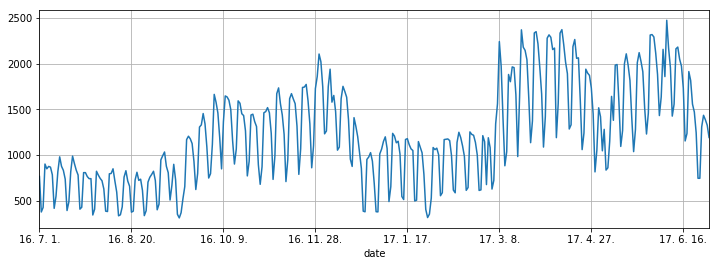

In [0]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True)

* **시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장합니다. 이 작업은 코드 [12]의 결과로 보이는 그래프를 설명할 간단한 함수를 찾기 위함입니다. 간단하게 말하면 현재 데이터를 간단한 모델로 표현하고 싶다는 뜻입니다. 이런 작업을 보통 '회귀(Regression)'라고 합니다.**

In [0]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

* **어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요합니다. 그러기 위해서는 참값과 비교해서 에러(error)를 계산해야 합니다. 그래서 아래 코드처럼 에러 함수를 정의합니다.**

In [0]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

**fp1 = np.polyfit(t, y_noise, 1)**

* **직선을 구성하는 것은 기울기와 절편입니다. 그 값을 알면 직선을 알게 되는 거죠...**
* **polyfit 명령으로 쉽게 찾을 수 있습니다. polyfit에서 세번쨰 인자는 찾고자 하는 함수의 차수입니다. 2를 넣어주면 2차식의 계수를 찾아달라고 하는 거죠.**

출처: https://pinkwink.kr/1127

In [0]:
np.polyfit(time, traffic, 1)

array([  2.94751137, 678.39950595])

In [0]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773021321143


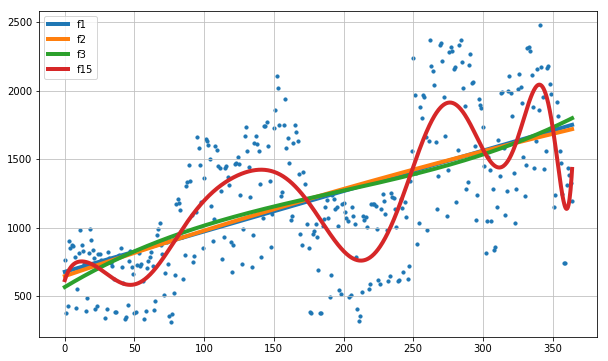

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(time, traffic, s = 10)

plt.plot(fx, f1(fx), lw = 4, label = 'f1')
plt.plot(fx, f2(fx), lw = 4, label = 'f2')
plt.plot(fx, f3(fx), lw = 4, label = 'f3')
plt.plot(fx, f15(fx), lw = 4, label = 'f15')

plt.grid(True, linestyle = '-', color = '0.75')

plt.legend(loc = 2)
plt.show()

---

## **7-2 Prophet 모듈을 이용한 forecast 예측**
* **Prophet 모듈은 사용법이 아주 간단합니다. 위의 pinkwink_web 변수에서 날짜(index)와 방문수(hit)만 따로 저장합니다. 그리고 날짜를 pandas가 지원하는 to_datetime 함수를 이용해서 날짜라고 선언합니다. 그리고 Prophet 함수를 사용할 때 주기성이 연단위(yearly_seasonality)로 있다고 선언합니다.**

In [0]:
df = pd.DataFrame({'ds': pinkwink_web.index, 'y': pinkwink_web['hit']})
df.reset_index(inplace = True)
df['ds'] = pd.to_datetime(df['ds'], format = "%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


* **아래 코드 [20]은 이후 60일간의 데이터를 예측하고 싶다는 make_future_dataframe 명령을 선언한 것입니다.**
* **코드 [21]은 예측한 데이터를 forecast 변수에 저장한 내용입니다.**

In [0]:
future = m.make_future_dataframe(periods = 60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,950.381120,741.665772,1165.838582
421,2017-08-26,535.440888,320.964535,734.189355
422,2017-08-27,667.756779,439.435418,863.847131
423,2017-08-28,1220.165548,1019.386610,1442.195883
424,2017-08-29,1255.791643,1037.438608,1472.295231


* **아래는 2017년 6월 말까지의 데이터 이후 약 2개월(60일)의 예측 결과입니다.**

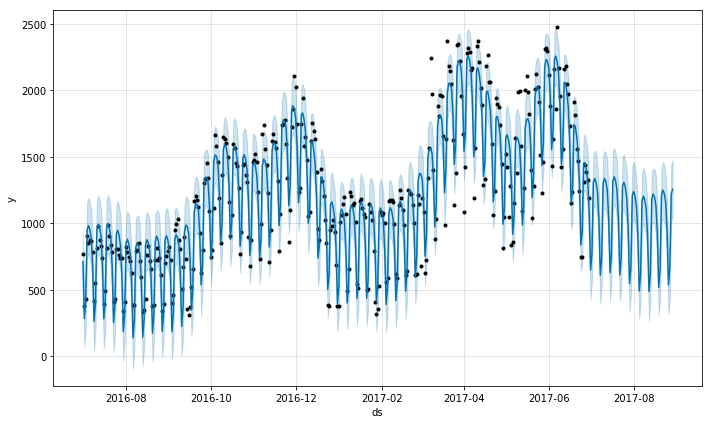

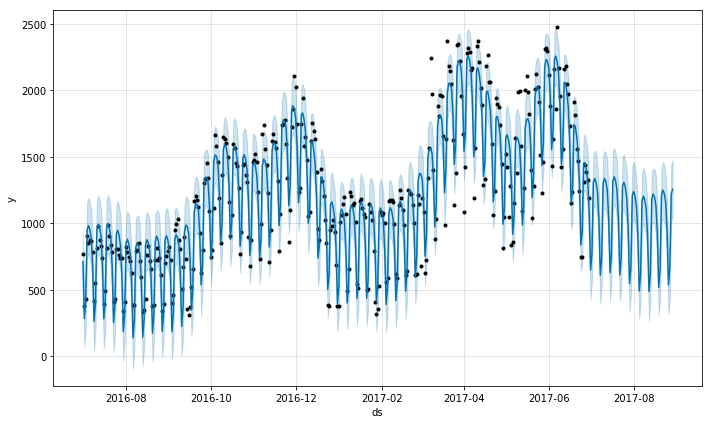

In [0]:
m.plot(forecast)

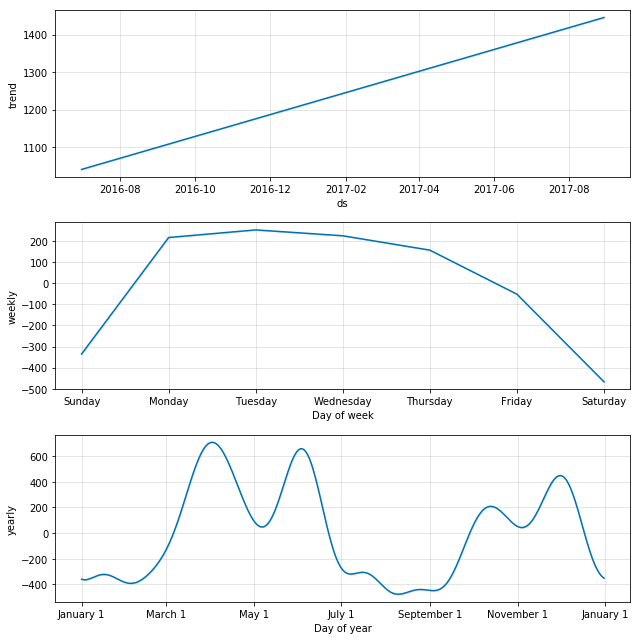

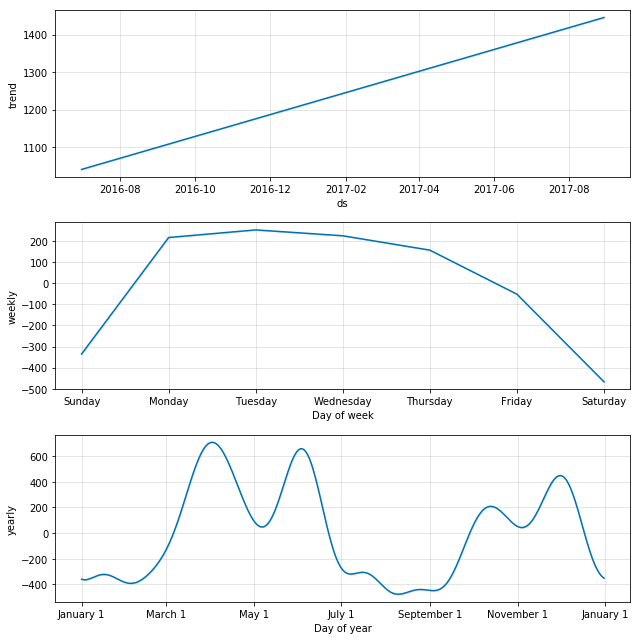

In [0]:
m.plot_components(forecast)

---

## **7-3 Seasonal 시계열 분석으로 주식 데이터 분석하기**
* **Pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있습니다. 바로 DataReader 함수입니다. 종목 코드를 알면 한국 kospi 주가 정보도 받아올 수 있습니다.**

In [0]:
import pandas_datareader.data as web

In [0]:
start = datetime(2003, 1, 1)
end = datetime(2017, 6, 30)

KIA = web.DataReader('KRX:000270', 'google', start, end)
KIA.head()

ImmediateDeprecationError: ignored

In [0]:
pip show pandas_datareader

Name: pandas-datareader
Version: 0.7.0
Summary: Data readers extracted from the pandas codebase,should be compatible with recent pandas versions
Home-page: https://github.com/pydata/pandas-datareader
Author: The PyData Development Team
Author-email: pydata@googlegroups.com
License: BSD License
Location: /usr/local/lib/python3.6/dist-packages
Requires: wrapt, lxml, pandas, requests
Required-by: 
